## Семинар 2 "Распознавание рукописных цифр"

ФИО: Миклин Артем Сергеевич

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [82]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
%matplotlib inline

In [83]:
import torch
torch.__version__

'1.3.1'

In [84]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [85]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.shape[0], -1) # !
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

In [86]:
X.shape, y.shape

((32, 784), (32,))

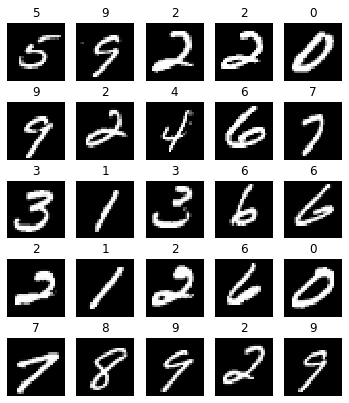

In [87]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [88]:
from IPython.display import clear_output
import sys

In [89]:
def train(network, epochs, learning_rate, plot=True,
          verbose=True, loss=None, train_loader = train_loader, test_loader = test_loader):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
#                 print(type(prediction), prediction.shape)
#                 print(prediction)
#                 return
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [90]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 28
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.308/0.302	Accuracy: 0.919/0.919

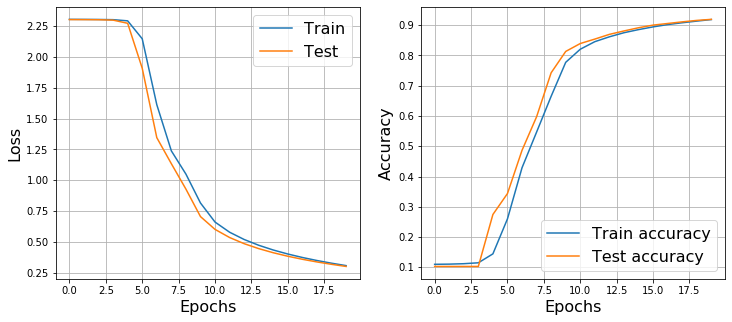

In [91]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01)

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [92]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass

In [93]:
class ELU:
    def __init__(self, a = 1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX
    
    def step(self, learning_rate):
        pass

Обучим сеть с функцией активации ReLU:

Epoch 19... (Train/Test) NLL: 0.035/0.085	Accuracy: 0.991/0.975

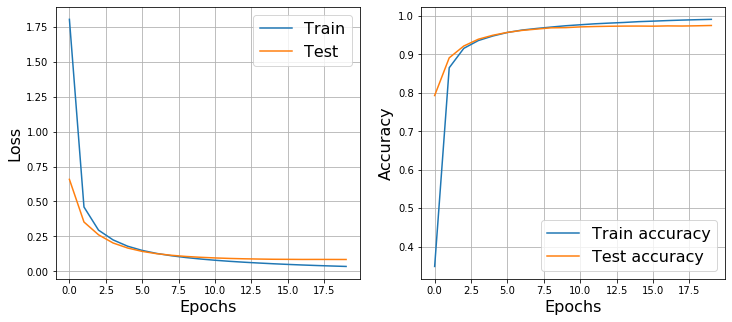

In [94]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 20, 0.01, plot=True, verbose=True)

Обучим сеть с функцией активации ELU:

Epoch 19... (Train/Test) NLL: 0.046/0.087	Accuracy: 0.987/0.973

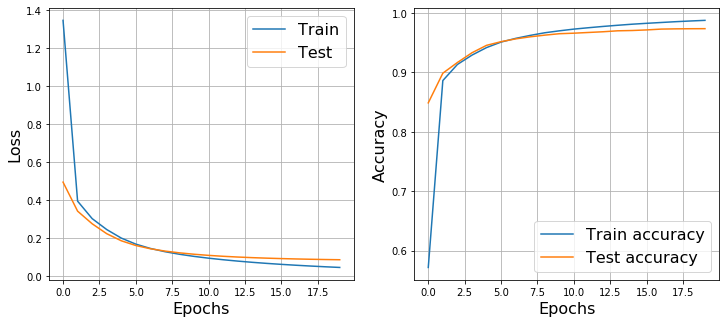

In [95]:
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)

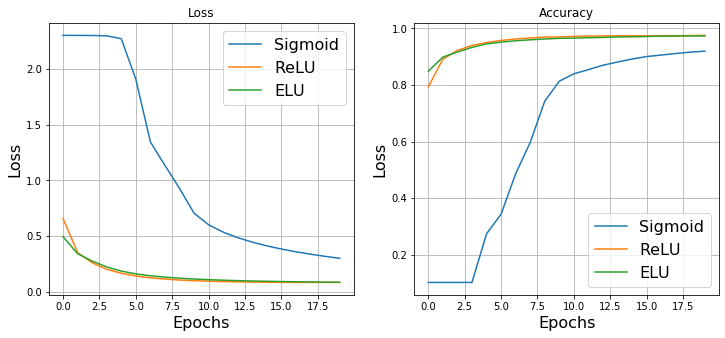

In [96]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### Часть 3: Анализ ошибок
На каких объектах сеть ошибается больше всего?

In [97]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

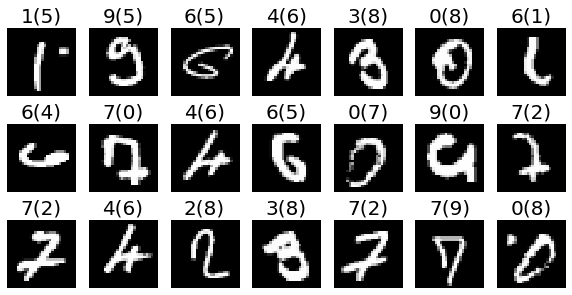

In [98]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

### HW1 (1 балл): Реализовать Tanh

In [99]:
class Tanh:
    def __init__(self):
        pass
    
    def th(self, X):
        ex = np.exp(X)
        e_x = np.exp(-X)
        return (ex - e_x) / (ex + e_x)

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X

        return self.th(X)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (1 - self.th(self.X)**2) * dLdy

    def step(self, learning_rate):
        pass

Обучим сеть с функцией активации Tanh:

Epoch 19... (Train/Test) NLL: 0.029/0.079	Accuracy: 0.994/0.977

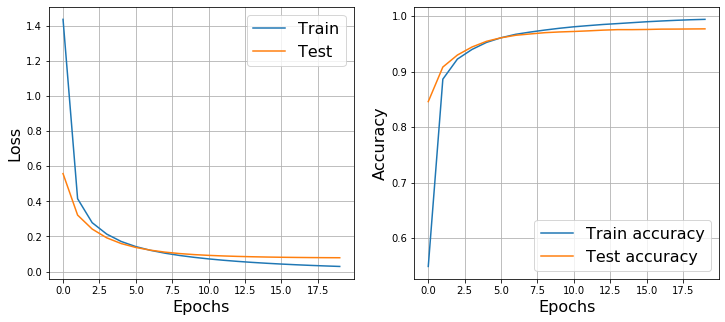

In [100]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()
tr_t, ts_t, tr_ac_t, ts_ac_t = train(network, 20, 0.01, plot=True, verbose=True)

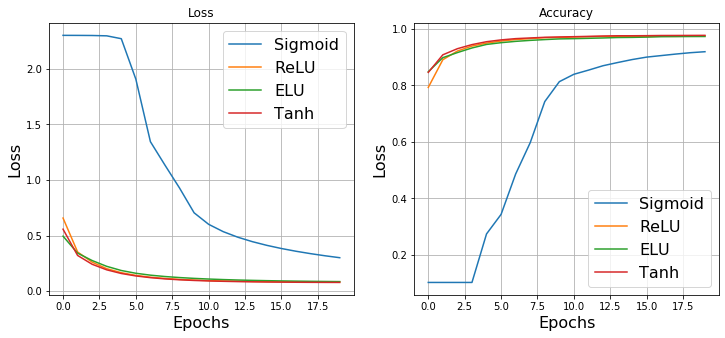

In [102]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.plot(ts_t, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.plot(ts_ac_t, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

In [103]:
augm_transform = transforms.Compose([
#                 transforms.RandomRotation(15, resample=False, expand=False, center=None, fill=0),
                transforms.RandomAffine(15, translate=(0.15,0.15), scale=None, shear=None, resample=False, fillcolor=0),
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
                    ])
augm_train_dataset = MNIST('.', train=True, download=True, transform=augm_transform)
augm_test_dataset = MNIST('.', train=False, transform=augm_transform)

augm_train_loader = DataLoader(augm_train_dataset, batch_size=32, shuffle=False)
augm_test_loader = DataLoader(augm_test_dataset, batch_size=32, shuffle=False)

In [108]:
type(augm_train_dataset)

torchvision.datasets.mnist.MNIST

In [104]:
## Usage example:
for X_augm, y_augm in augm_train_loader:
    X_augm = X_augm.view(X_augm.shape[0], -1) # !
    X_augm = X_augm.numpy() ### Converts torch.Tensor to numpy array
    y_augm = y_augm.numpy()
    pass

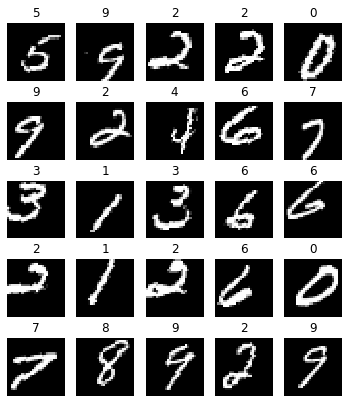

In [105]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X_augm[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y_augm[i])
    plt.axis('off')

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

Epoch 0... (Train/Test) NLL: 2.299/2.283	Accuracy: 0.119/0.204

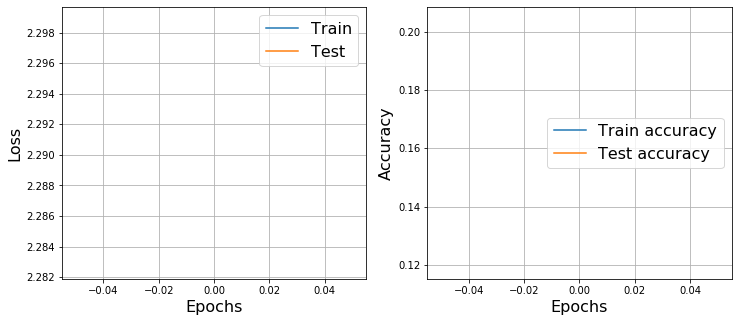

In [115]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_ra, ts_ra, tr_ac_ra, ts_ac_ra = train(network, 20, 0.01, plot=True, verbose=True,
                                        train_loader = augm_train_loader, 
                                        test_loader = augm_test_loader
                                        )

In [110]:
from torch.utils.data import ConcatDataset

In [113]:
comb_train_dataset = ConcatDataset([train_dataset, augm_train_dataset])
comb_test_dataset = ConcatDataset([train_dataset, augm_train_dataset])

comb_train_loader = DataLoader(comb_train_dataset, batch_size=32, shuffle=False)
comb_test_loader = DataLoader(comb_test_dataset, batch_size=32, shuffle=False)

Epoch 19... (Train/Test) NLL: 0.100/0.111	Accuracy: 0.969/0.966

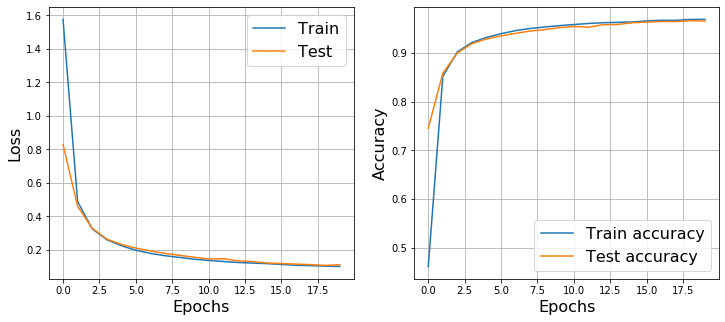

In [116]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_ra, ts_ra, tr_ac_ra, ts_ac_ra = train(network, 20, 0.01, plot=True, verbose=True,
                                        train_loader = comb_train_loader, 
                                        test_loader = comb_test_loader
                                        )

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?